In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astroduet.bbmag import bb_abmag_fluence
from astroduet.image_utils import construct_image, find
from astroduet.config import Telescope
from astroduet.background import background_pixel_rate

from astroduet.diff_image import py_zogy
from astroduet.image_utils import estimate_background

duet = Telescope()
duet.info()


[bgd_band1, bgd_band2] = background_pixel_rate(duet, low_zodi = True, diag=True)

read_noise = duet.read_noise


# Define image simulation parameters
exposure = 300 * u.s
frame = np.array([30,30]) # Dimensions of the image I'm simulating in DUET pixels (30x30 ~ 3x3 arcmin)

-----
        DUET Telescope State: baseline
        Physical Entrance Pupil: 26.0 cm
        Effective EPD: 24.2 cm
        Effective Area: 459.9605804120816 cm2
        Transmission Efficiency: 0.8166518036622619
        
        Pixel size: 6.4 arcsec
        Pointing RMS: 2.5 arcsec
        DIQ RMS: 4.406714876186114 arcsec
        Effective PSF FWHM: 12.5 arcsec
        N_eff: 9.75310538172716

        Band 1: {'eff_wave': <Quantity 202.56878682 nm>, 'eff_width': <Quantity 53.32814342 nm>}
        Bandpass 1: [175.90471511 229.23285853] nm
        Band 2: {'eff_wave': <Quantity 281.7531854 nm>, 'eff_width': <Quantity 68.16239088 nm>}
        Bandpass 2: [247.67198996 315.83438085] nm

        Dark current: 0.0115 ph / s
        Read noise (RMS per read): 7
        -----
        
-----
Background Computation Integrating over Pixel Area
Telescope diameter: 26.0 cm
Transmission Efficiency: 0.8166518036622619


Pixel Size: 6.4 arcsec
Pixel Area: 40.96000000000001 arcsec2

Zodi Level: 

In [4]:
# Define source
bbtemp = 20000 * u.K
swiftmag = 18 * u.ABmag

src_fluence1, src_fluence2 = bb_abmag_fluence(bbtemp=bbtemp, swiftmag=swiftmag, duet=duet)
print("Source fluences: {}, {}".format(src_fluence1,src_fluence2))
src_rate1 = duet.trans_eff * duet.eff_area * src_fluence1
print("Source rate (band 1): {}".format(src_rate1))

# Define galaxy
galaxy = 'dwarf'
gal_params = None


Source fluences: 0.032113008404959516 ph / (cm2 s), 0.03029734679215195 ph / (cm2 s)
Source rate (band 1): 12.062533483610837 ph / s


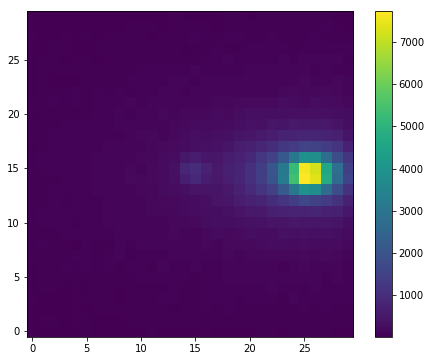

In [5]:
# Construct the simulated image
image = construct_image(frame, exposure, source=src_rate1,
                        gal_type=galaxy, gal_params=gal_params, 
                        sky_rate=bgd_band1, duet=duet)

plt.figure(figsize=[8,6])
plt.imshow(image.value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()

DAOPhot find:

Find peaks:


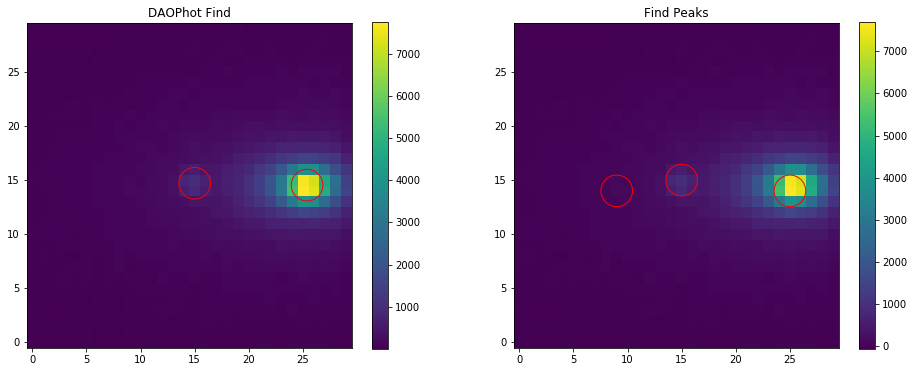

In [6]:
# Single-exposure point source detection

# Run DAOPhot-like Find command
print("DAOPhot find:")
psf_fwhm_pix = duet.psf_fwhm / duet.pixel

star_tbl, bkg_image, threshold = find(image,psf_fwhm_pix.value,method='daophot',frame='single')

plt.figure(figsize=[16,6])
plt.subplot(121)
plt.title('DAOPhot Find')
plt.imshow(image.value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()
plt.scatter(star_tbl['x'],star_tbl['y'],marker='o',s=1000,facecolors='none',edgecolors='r',lw=1)

# Run find_peaks command
print("\nFind peaks:")
star_tbl, bkg_image, threshold = find(image,psf_fwhm_pix.value,method='peaks',frame='single')

plt.subplot(122)
plt.title('Find Peaks')
plt.imshow((image-bkg_image).value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()
plt.scatter(star_tbl['x'],star_tbl['y'],marker='o',s=1000,facecolors='none',edgecolors='r',lw=1)

Real source count rate: 12.062533483610837 ph / s
xcenter ycenter aperture_sum aper_sum_bkgsub aperture_sum_err
  pix     pix      ph / s         ph / s          ph / s     
------- ------- ------------ --------------- ----------------
      9      14    3.8008786      0.57289218       0.12852255
     25      14    140.01173       74.921857       0.68596954
     15      15    17.345172       8.7921862       0.24832578


      x_fit              y_fit             flux_fit          flux_unc    
                                              ph                ph       
------------------ ------------------ ----------------- -----------------
 9.718876901240376 14.208044494256884 1241.609775572059               0.0
 25.36586512034467 14.476453400723804  58185.3695694314 6521.127122884643
15.010194988347616   14.7137602536282 6566.123183686525 847.0056943425969


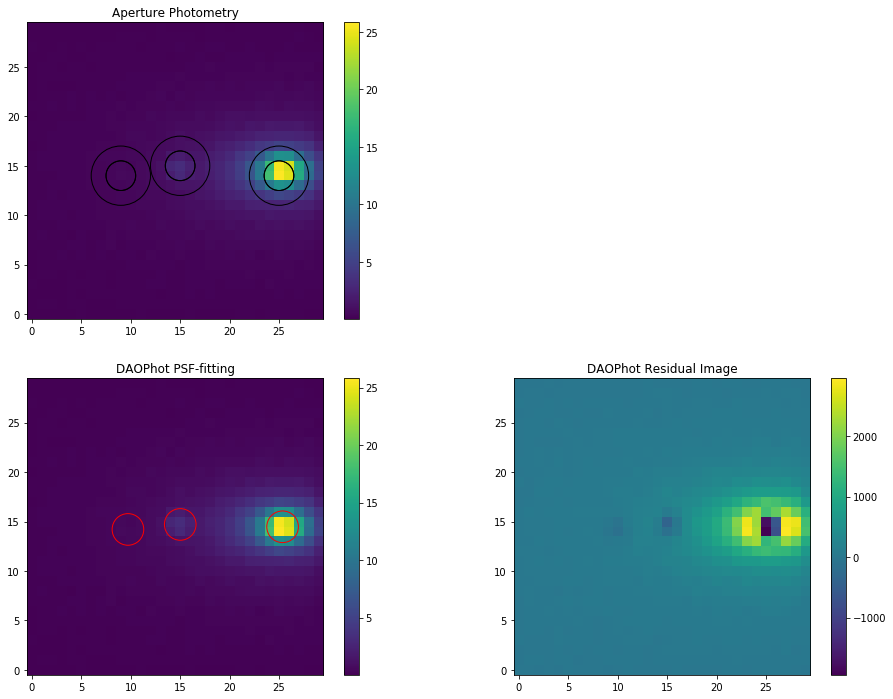

In [7]:
# Single-exposure photometry
print("Real source count rate: {}".format(src_rate1))

# Convert to count rate
image_rate = image / exposure

from astroduet.image_utils import run_daophot, ap_phot

# Run aperture photometry
result, apertures, annulus_apertures = ap_phot(image_rate,star_tbl,read_noise,exposure)
print(result['xcenter','ycenter','aperture_sum','aper_sum_bkgsub','aperture_sum_err'])

print("\n")

# Run PSF-fitting photometry
result, residual_image = run_daophot(image,threshold,star_tbl,niters=1)
print(result['x_fit','y_fit','flux_fit','flux_unc'])

# Plots
plt.figure(figsize=[16,12])
plt.subplot(221)
plt.title('Aperture Photometry')
plt.imshow(image_rate.value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()
apertures.plot()
annulus_apertures.plot()

plt.subplot(223)
plt.title('DAOPhot PSF-fitting')
plt.imshow(image_rate.value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()
plt.scatter(result['x_fit'],result['y_fit'],marker='o',s=1000,facecolors='none',edgecolors='r',lw=1)

plt.subplot(224)
plt.title('DAOPhot Residual Image')
plt.imshow(residual_image.value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()

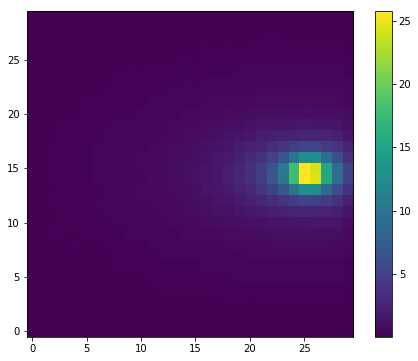

In [8]:
# Part 2, simulate reference image, without source, 5 exposures
# Currently a perfect co-add
n_exp = 5
ref_image = construct_image(frame, exposure, \
                            gal_type=galaxy, gal_params=gal_params, source=None, sky_rate=bgd_band1, n_exp=n_exp)
ref_image_rate = ref_image / (n_exp * exposure)
plt.figure(figsize=[8,6])
plt.imshow(ref_image_rate.value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()

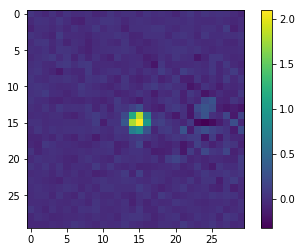

In [9]:
# Part 3, make a difference image

# Make a 2D array containing the PSF (oversample then bin up for more accurate PSF)

oversample = 5
pixel_size_init = duet.pixel / oversample

psf_model = duet.psf_model(pixel_size=pixel_size_init, x_size=25, y_size=25)

psf_os = psf_model.array

#psf_os = gaussian_psf(psf_fwhm,(25,25),pixel_size_init)
shape = (5, 5, 5, 5)
psf_array = psf_os.reshape(shape).sum(-1).sum(1)

# Use ZOGY algorithm to create difference image
image_bkg, image_bkg_rms_median = estimate_background(image_rate, sigma=2, method='1D')
ref_bkg, ref_bkg_rms_median = estimate_background(ref_image_rate, sigma=2, method='1D')
image_rate_bkgsub, ref_rate_bkgsub = image_rate - image_bkg, ref_image_rate - ref_bkg

s_n, s_r = np.sqrt(image_rate), np.sqrt(ref_image_rate) # 2D uncertainty (sigma) - that is, noise on the background
sn, sr = np.mean(s_n), np.mean(s_r) # Average uncertainty (sigma)
dx, dy = 0.1, 0.01 # Astrometric uncertainty (sigma)
diff_image, d_psf, s_corr = py_zogy(image_rate_bkgsub.value,
                                    ref_rate_bkgsub.value,
                                    psf_array,psf_array,
                                    s_n.value,s_r.value,
                                    sn.value,sr.value,dx,dy)

diff_image *= image_rate_bkgsub.unit
plt.imshow(diff_image.value)
plt.colorbar()
plt.show()

Real source count rate: 12.062533483610837 ph / s
threshold =  0.3225035746938884 ph / s
xcenter ycenter aperture_sum aper_sum_bkgsub aperture_sum_err percent_error
  pix     pix      ph / s         ph / s          ph / s                   
------- ------- ------------ --------------- ---------------- -------------
     15      15    8.9821469       8.6240053       0.18381768     2.1314653


 id      flux_fit            flux_unc        percent_error   
          ph / s              ph / s             ph / s      
--- ------------------ ------------------- ------------------
  1 12.088368070265565 0.28305071234036244 2.3415130205755244


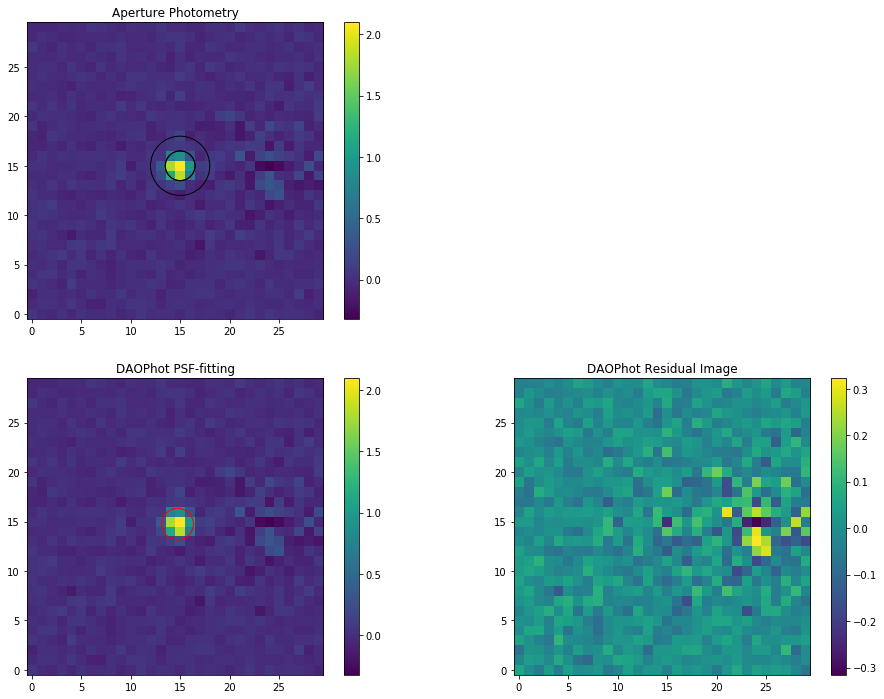

In [10]:
# Part 4, find and photometry on the difference image
print("Real source count rate: {}".format(src_rate1))

# Run find
star_tbl, bkg_image, threshold = find(diff_image,psf_fwhm_pix.value,method='peaks')
print('threshold = ', threshold)

# Run aperture photometry
result, apertures, annulus_apertures = ap_phot(diff_image,star_tbl,read_noise,exposure)
result['percent_error'] = result['aperture_sum_err'] / result['aper_sum_bkgsub'] * 100
print(result['xcenter','ycenter','aperture_sum','aper_sum_bkgsub','aperture_sum_err','percent_error'])

print("\n")

# Run PSF-fitting photometry
result, residual_image = run_daophot(diff_image,threshold,star_tbl,niters=1)
result['percent_error'] = result['flux_unc'] / result['flux_fit'] * 100
print(result['id','flux_fit','flux_unc','percent_error'])

# Plots
plt.figure(figsize=[16,12])
plt.subplot(221)
plt.title('Aperture Photometry')
plt.imshow(diff_image.value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()
apertures.plot()
annulus_apertures.plot()

plt.subplot(223)
plt.title('DAOPhot PSF-fitting')
plt.imshow(diff_image.value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()
plt.scatter(result['x_fit'],result['y_fit'],marker='o',s=1000,facecolors='none',edgecolors='r',lw=1)

plt.subplot(224)
plt.title('DAOPhot Residual Image')
plt.imshow(residual_image.value, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()